In [59]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import keras_tuner as kt
from tensorflow_addons.metrics import RSquare
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [2]:
# setting the constants
SHUFFLE_BUFFER = 500
BATCH_SIZE = 32
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

##### Utility functions

In [3]:
def input_mix_dtypes(df, binary_feature_names=[], 
                     categorical_feature_names=[]):
    '''
    It returns dictionary of tensors. It creates the "placeholder" for 
    input tensor from DataFrame.
    '''
    inputs = {}
    for name, column in df.items():
        # setting the right dtype
        if type(column[0]) == str:
            dtype = tf.string
        elif (name in categorical_feature_names or
                name in binary_feature_names):
            dtype = tf.int64 # categorical integer
        else:
            dtype = tf.float32
        inputs[name] = tf.keras.Input(
            shape=(), # scalar input
            name=name, 
            dtype=dtype 
        )
    return inputs

In [4]:
def binary_preprocessor(preprocessed_list, inputs, binary_feature_names):
    '''
    It appends the binary preprocessors tensors to list of preprocessors. No transformation
    performed other than adding a new axia and casting
    '''
    for name in binary_feature_names:
        inp_bin = inputs[name]
        inp_bin_nw_axis = inp_bin[:, tf.newaxis]
        inp_bin_float = tf.cast(inp_bin_nw_axis, tf.float32)
        preprocessed_list.append(inp_bin_float) #the tensor, not the input dict
    return None

In [5]:
# numeric processing
def stack_dict(dict, function=tf.stack):
    '''
    take a dict of pd.Series or a dict of tensors and turns it into a tensor. Used for
    formating the input for adapt operation.
    '''
    values = [] #list of tensors
    for key in sorted(dict.keys()):
        # sort to ensure later matching to preserve order
        input_float = tf.cast(dict[key], tf.float32) 
        values.append(input_float)
    tensor_stacked = function( # stacks the list of tensors into a single one
                    values,
                    axis=-1 # last axis direction, in this case 1?
                    ) 
    return tensor_stacked

def numeric_preprocessor(df_adapter, stack_dict, preprocessed_list, 
                         inputs, numeric_feature_names):
    '''
    It appends the numeric preprocessor tensor to list of preprocessors. Normalization layer
    is used for trasnformation. 
    '''
    # adapting the normalizer
    df_adapter = df_adapter[numeric_feature_names]
    normalizer = tf.keras.layers.Normalization(axis=-1)
    tensor_dfcolumns = stack_dict(dict(df_adapter))
    normalizer.adapt(tensor_dfcolumns) # equivalent to fit

    #input for numeric only
    inputs_numeric = {}
    for name in numeric_feature_names:
        inputs_numeric[name] = inputs[name]

    tensor_numeric_inputs = stack_dict(inputs_numeric)
    numeric_normalized = normalizer(tensor_numeric_inputs) # similar to transform

    preprocessed_list.append(numeric_normalized)
    return None

In [6]:
# categorical processing
def categorical_preprocessor(df_adapter, preprocessed_list, 
                             inputs, categorical_feature_names):
    '''
    It appends the categorical preprocessors tensors to list of preprocessors. It adds a 
    a new axis to each input tensor and then adds a lookup layer.
    '''
    for name in categorical_feature_names:
        vocab = sorted(set(df_adapter[name]))

        # create lookup layers
        if type(vocab[0]) is str:
            lookup = tf.keras.layers.StringLookup(vocabulary=vocab, 
                                                  output_mode='one_hot')
        else:
            lookup = tf.keras.layers.IntegerLookup(vocabulary=vocab, 
                                                   output_mode='one_hot')
        
        input = inputs[name][:,tf.newaxis] # for compatibility
        one_hot_tensor = lookup(input)
        preprocessed_list.append(one_hot_tensor)
    return None

In [7]:
def preprocessor_model(numeric_feature_names,
                       binary_feature_names, 
                       categorical_feature_names,
                       X_train,
                       df, #consider all categories
                       inputs):
    '''
    It returns the preprocessor model. Take the names of inputs for preserving order
    '''
    preprocessed_list = [] # list of input, preprocessed tensors

    binary_preprocessor(preprocessed_list, inputs, binary_feature_names)
    numeric_preprocessor(X_train,  stack_dict, preprocessed_list, 
                         inputs, numeric_feature_names)
    categorical_preprocessor(df, preprocessed_list, inputs, 
                             categorical_feature_names)

    preprocessed_result = tf.concat(preprocessed_list, axis=-1) # preprocessed tensor

    # creating the preprocessing model
    preprocessor = tf.keras.Model(inputs, preprocessed_result)
    return preprocessor

In [55]:
def plot_metrics(metrics, history):
    """
    It plots the defined metrics per epoch
    """

    num_metrics = len(metrics)
    num_rows = (num_metrics + 1) // 2  # Compute the number of rows based on the number of metrics
    
    # Create the grid of subplots
    fig, axs = plt.subplots(num_rows, 2, figsize=(10, 8))

    # Flatten the subplots array for easy iteration
    axs = axs.flatten()

    # Iterate over the metrics and corresponding subplots
    for i, metric in enumerate(metrics):
        # Plot train metric
        axs[i].plot(history.history[metric])
        
        # Plot validation metric
        axs[i].plot(history.history['val_' + metric])
        
        # Set subplot title and labels
        title = metric.replace('_', ' ')
        axs[i].set_title(title)
        axs[i].set_ylabel('Loss')
        axs[i].set_xlabel('Epoch')
        axs[i].legend(['Train', 'Validation'], loc='upper right')

    # Adjust spacing between subplots
    plt.tight_layout()

    # Display the plot
    plt.show()

#### Model building

In [8]:
# importing and splitting
data_path = '../data/real_state_data_for_model.csv'
df = pd.read_csv(data_path)

# defining the features and variables
X = df.drop('precio', axis=1)
y = df['precio']
y_stratify = X[['tipo_de_propiedad']] # keep proportions for this variable

# train-val-test splitting
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size = 0.30, 
    random_state=RANDOM_SEED,
    stratify=y_stratify,
)

y_stratify = X_test[['tipo_de_propiedad']]
X_val, X_test, y_val, y_test = train_test_split(
    X_test, 
    y_test, 
    test_size = 0.5, 
    random_state=RANDOM_SEED,
    stratify=y_stratify,
)

# variables for transformations 
numeric_feature_names = ['no_baños', 'terreno_m2', 'año_constr',
                        'no_dormitorios', 'area_constr_m2', 'latitud', 
                        'longitud', 'estacionamientos', 'ambientes']
categorical_feature_names = ['tipo_de_propiedad', 'ciudad', 'zona']
binary_feature_names = []


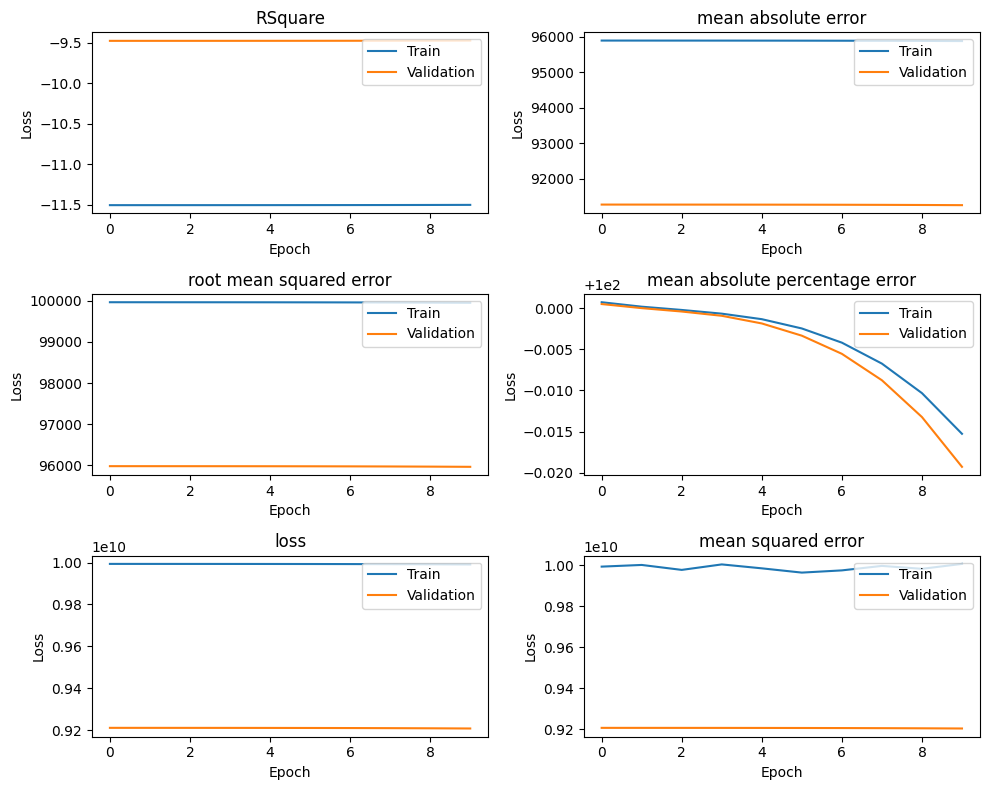

In [72]:
# baseline model

# create dict of input tensors 
inputs = input_mix_dtypes(X_train, binary_feature_names, 
                          categorical_feature_names)

# create preprocessor
preprocessor = preprocessor_model(numeric_feature_names, binary_feature_names, 
                                  categorical_feature_names, X_train, X, inputs)

body = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='relu',),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1),
])

preprocessed_tensor = preprocessor(inputs)
result_tensor = body(preprocessed_tensor)
model = tf.keras.Model(inputs, result_tensor)

model.compile(optimizer='adam',
    loss=tf.keras.losses.MeanSquaredError(name='mean_squared_error'),
        metrics=[
        RSquare(name='RSquare'), #all metrics are normalized
        tf.keras.losses.MeanSquaredError(name="mean_squared_error"),
        tf.keras.metrics.MeanAbsoluteError(name='mean_absolute_error'),
        tf.keras.metrics.RootMeanSquaredError(name='root_mean_squared_error'),
        tf.keras.metrics.MeanAbsolutePercentageError(name="mean_absolute_percentage_error"),
    ]
)

history_base_model = model.fit(dict(X_train), y_train, epochs=10, 
                    batch_size=BATCH_SIZE, verbose=0,
                    validation_data=(dict(X_val), y_val),
                    )

metrics = ['RSquare', 'mean_absolute_error', 'root_mean_squared_error', 
           'mean_absolute_percentage_error', 'loss', 'mean_squared_error']
           # loss and mean_squared_error are the same
           
plot_metrics(metrics, history_base_model)

In [90]:
# visualizing the preprocessor
#tf.keras.utils.plot_model(preprocessor, rankdir="LR", show_shapes=True, expand_nested=True)

# plot the model
#tf.keras.utils.plot_model(model, rankdir="LR",expand_nested=True)


#### Hiperparameter tuning

In [67]:
def compiled_model(hp,
                   learning_rate,
                   layers,
                   activation,
                   ): # if input_mix_dtypes, preprocessor_model are defined it works

    # create dict of input tensors 
    inputs = input_mix_dtypes(X_train, binary_feature_names, 
                            categorical_feature_names)

    # create preprocessor
    preprocessor = preprocessor_model(numeric_feature_names, binary_feature_names, 
                                    categorical_feature_names, X_train, X, inputs)

    # building the body
    body = tf.keras.Sequential()
    for i in range(layers):
        neurons = hp.Int(f"units_{i}", min_value=30, max_value=150, step=10)
        regularization_kernel = hp.Float(f"r_k{i}", min_value=1e-2, 
                                        max_value=100, sampling="log")
        regularization_bias = hp.Float(f"r_b{i}", min_value=1e-2, 
                                        max_value=100, sampling="log")
        body.add(tf.keras.layers.Dense(
            neurons, 
            activation=activation,
            kernel_regularizer=tf.keras.regularizers.L2(regularization_kernel),
            bias_regularizer=tf.keras.regularizers.L2(regularization_bias),
            )
        )
    body.add(tf.keras.layers.Dense(1))

    # building the final model
    preprocessed_tensor = preprocessor(inputs)
    result_tensor = body(preprocessed_tensor)
    model = tf.keras.Model(inputs, result_tensor)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.MeanSquaredError(name='mean_squared_error'),
        metrics=[
            tf.keras.metrics.MeanAbsoluteError(name='mean_absolute_error'),
            tf.keras.metrics.RootMeanSquaredError(name='root_mean_squared_error'),
            tf.keras.metrics.MeanAbsolutePercentageError(name="mean_absolute_percentage_error"),
        ]
    )
    return model

def build_model(hp):
    activation = hp.Choice("activation", ["selu"]) #["relu", "tanh", "selu"])
    layers = 5 #hp.Int("layers", min_value=1, max_value=5, step=1)
    learning_rate = hp.Float("lr", min_value=1e-5, max_value=0.1, sampling="log")

    # call existing model-building code with the hyperparameter values.
    model = compiled_model(hp,
                   learning_rate,
                   layers,
                   activation,
                   )
    return model


tuner = kt.Hyperband(
                     build_model,
                     objective= kt.Objective("val_root_mean_squared_error", direction="min"),
                     max_epochs=150,
                     factor=10,
                     directory='my_dir',
                     project_name='intro_to_kt',
                     overwrite=True
                     )

# hyperparameters search
tuner.search(dict(X_train), y_train, epochs=100, batch_size=BATCH_SIZE,
            validation_data=(dict(X_val), y_val))

Trial 176 Complete [00h 00m 44s]
val_root_mean_squared_error: 19049.451171875

Best val_root_mean_squared_error So Far: 9782.3173828125
Total elapsed time: 00h 27m 51s
INFO:tensorflow:Oracle triggered exit


Best epoch: 36


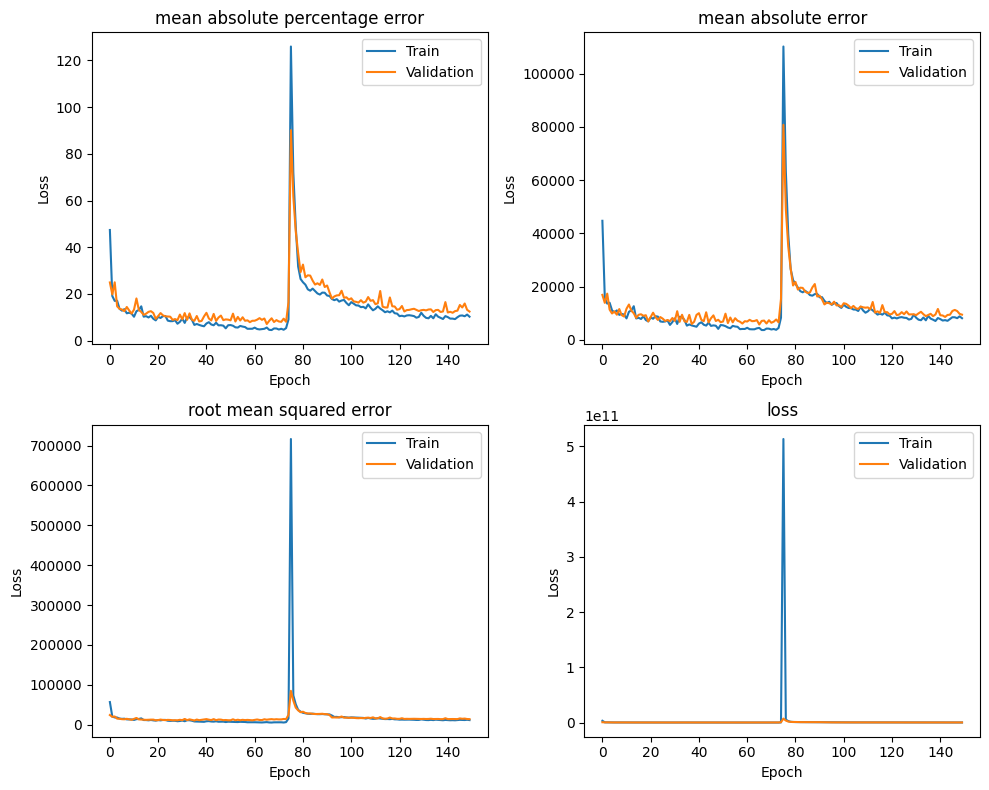

In [69]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# optimal epochs search
model = tuner.hypermodel.build(best_hps)
history = model.fit(dict(X_train), y_train, epochs=150, 
                    validation_data=(dict(X_val), y_val), verbose=0)

val_loss_per_epoch = history.history['val_loss']

best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

metrics_hipersearch = ['mean_absolute_percentage_error', 'mean_absolute_error',
           'root_mean_squared_error', 'loss']
plot_metrics(metrics, history)

In [91]:
# get final model
best_model = tuner.hypermodel.build(best_hps)

history = best_model.fit(dict(X_train), y_train, epochs=best_epoch, validation_data=(dict(X_val), y_val))

Epoch 1/36
32/32 [==============================] - 1s 16ms/step - loss: 3894842368.0000 - mean_absolute_error: 51861.5898 - root_mean_squared_error: 62408.4961 - mean_absolute_percentage_error: 55.4313 - val_loss: 732829696.0000 - val_mean_absolute_error: 20902.4648 - val_root_mean_squared_error: 27070.0762 - val_mean_absolute_percentage_error: 29.9673
Epoch 2/36
32/32 [==============================] - 0s 9ms/step - loss: 611341760.0000 - mean_absolute_error: 19232.8242 - root_mean_squared_error: 24724.3145 - mean_absolute_percentage_error: 23.2326 - val_loss: 320013120.0000 - val_mean_absolute_error: 14645.5986 - val_root_mean_squared_error: 17887.3535 - val_mean_absolute_percentage_error: 18.9273
Epoch 3/36
32/32 [==============================] - 0s 8ms/step - loss: 334882496.0000 - mean_absolute_error: 14089.7979 - root_mean_squared_error: 18298.1992 - mean_absolute_percentage_error: 17.1897 - val_loss: 303169472.0000 - val_mean_absolute_error: 13037.8887 - val_root_mean_squared_

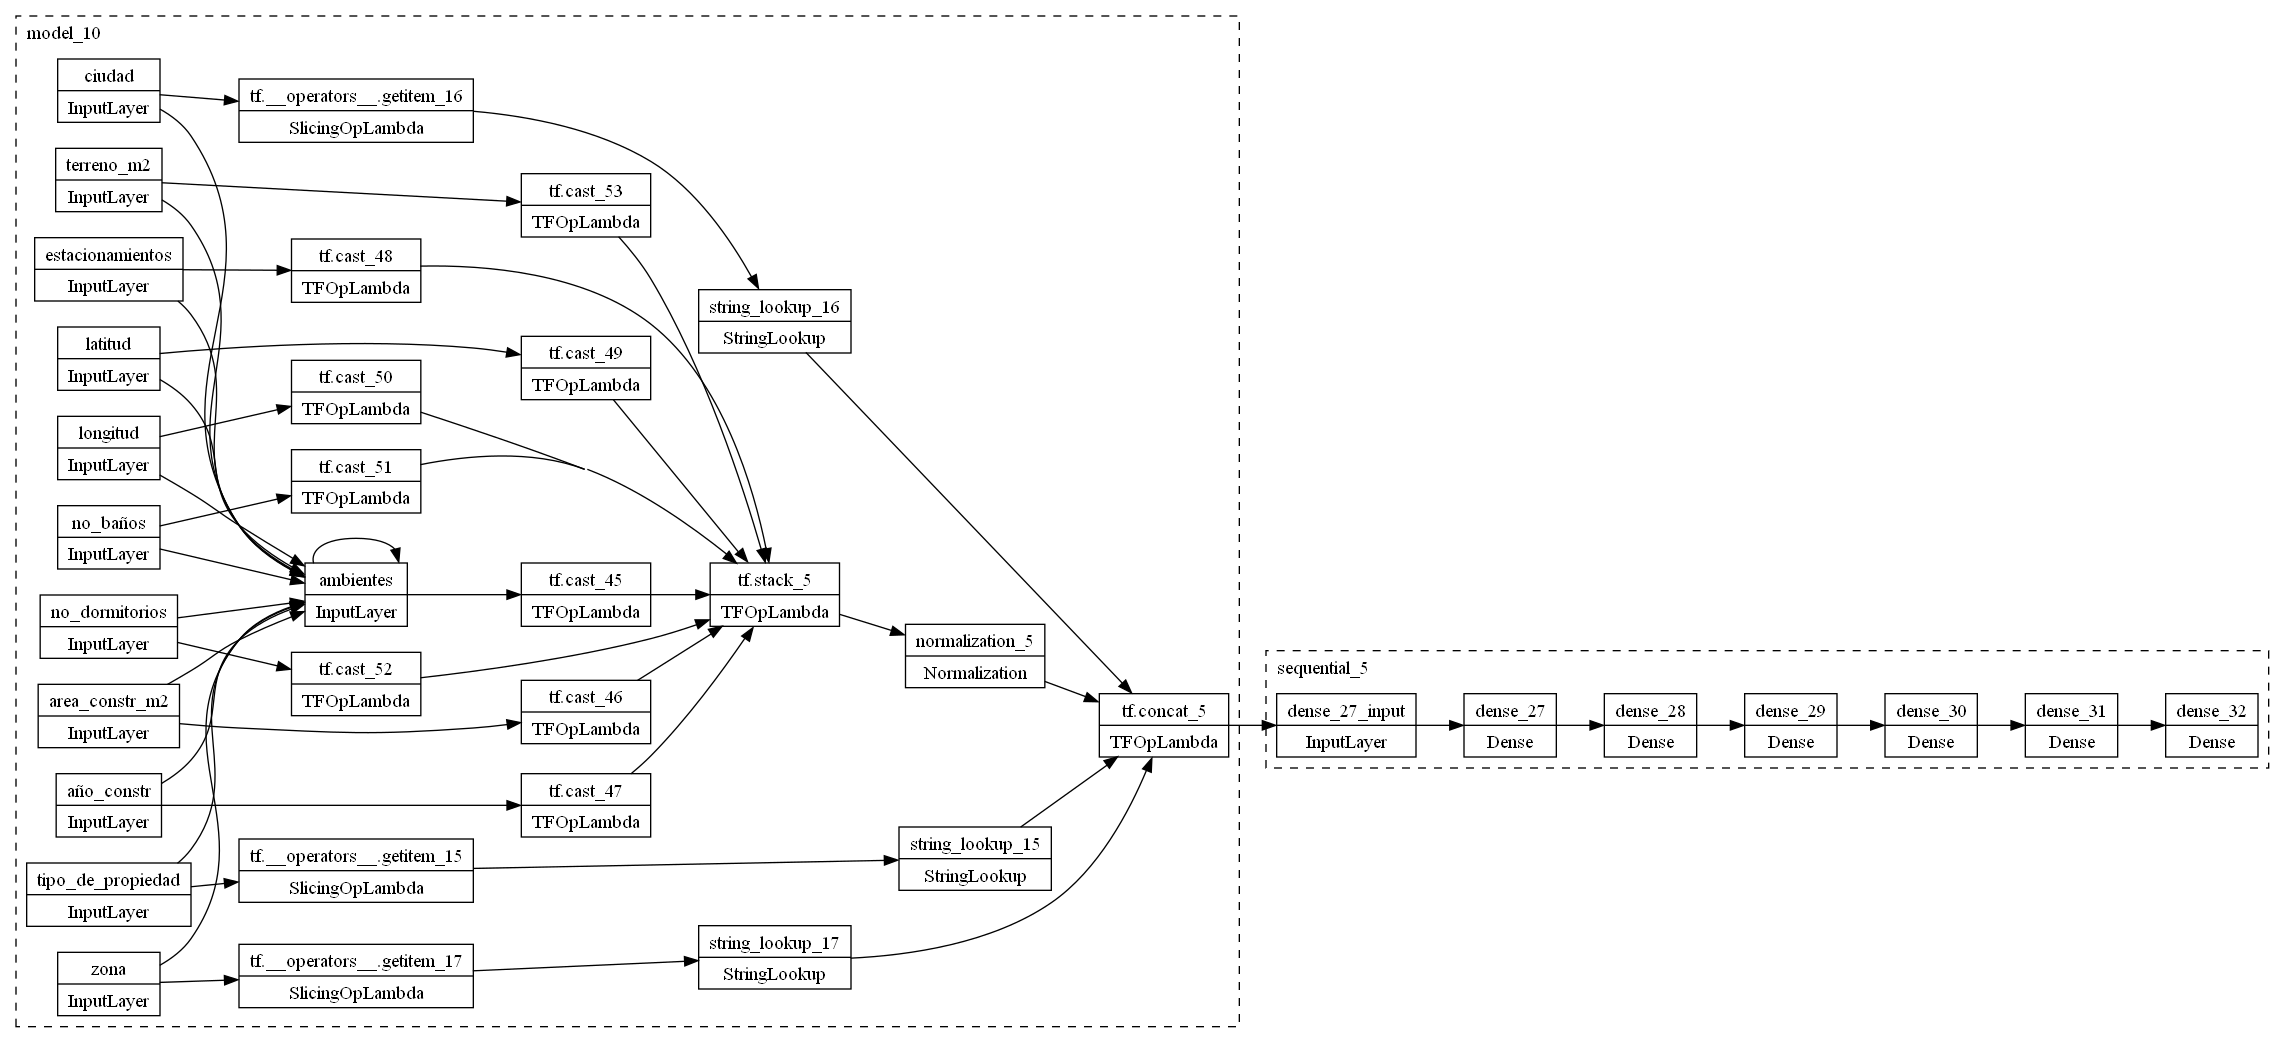

In [92]:
# visualizing model structure
tf.keras.utils.plot_model(best_model, rankdir="LR",expand_nested=True)

Training set
32/32 - 0s - loss: 78074368.0000 - mean_absolute_error: 6721.1665 - root_mean_squared_error: 8829.1426 - mean_absolute_percentage_error: 7.5075 - 180ms/epoch - 6ms/step
[78074368.0, 6721.16650390625, 8829.142578125, 7.507481575012207]
32/32 [==============================] - 0s 4ms/step
r2 score2 training 0.9024747735779048
Validation set
7/7 - 0s - loss: 117016752.0000 - mean_absolute_error: 7792.6094 - root_mean_squared_error: 10811.8525 - mean_absolute_percentage_error: 9.1304 - 74ms/epoch - 11ms/step
[117016752.0, 7792.609375, 10811.8525390625, 9.130358695983887]
7/7 [==============================] - 0s 4ms/step
r2 score2 validation 0.8670318983245928
Test set
7/7 - 0s - loss: 137655616.0000 - mean_absolute_error: 8676.3115 - root_mean_squared_error: 11727.5322 - mean_absolute_percentage_error: 9.9574 - 53ms/epoch - 8ms/step
[137655616.0, 8676.3115234375, 11727.5322265625, 9.957446098327637]
7/7 [==============================] - 0s 4ms/step
r2 score2 test 0.831130771

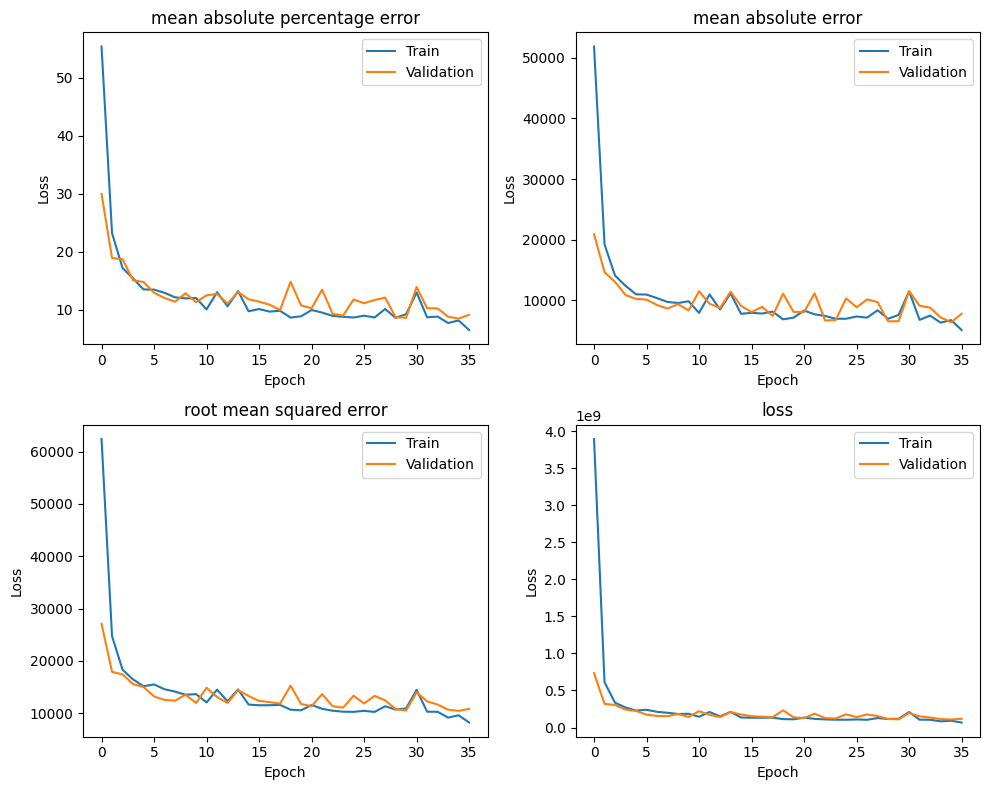

In [95]:
# evaluating the final model
print('Training set')
print(best_model.evaluate(dict(X_train),  y_train, verbose=2))
print('r2 score2 training', r2_score(y_train, best_model.predict(dict(X_train))))
print('Validation set')
print(best_model.evaluate(dict(X_val),  y_val, verbose=2))
print('r2 score2 validation', r2_score(y_val, best_model.predict(dict(X_val))))
print('Test set')
print(best_model.evaluate(dict(X_test),  y_test, verbose=2))
print('r2 score2 test', r2_score(y_test, best_model.predict(dict(X_test))))

plot_metrics(metrics_hipersearch, history)

#### Exporting the model

In [96]:
# exporting and importing the model
print(best_model.predict(dict(X_train.iloc[:1])))
best_model.save('model.h5')
model_1 = tf.keras.models.load_model('model.h5')
print(model_1.predict(dict(X_train.iloc[:1])))

1/1 [==============================] - 0s 24ms/step
[[80905.586]]
1/1 [==============================] - 0s 117ms/step
[[80905.586]]


#### Debugging

In [97]:
data = {
    'ambientes': [7],
    'no_baños': [2],
    'terreno_m2': [393],
    'año_constr': [2013],
    'no_dormitorios': [3],
    'area_constr_m2': [100.0],
    'estacionamientos': [4],
    'latitud': [-17.643187],
    'longitud': [-63.173777],
    'tipo_de_propiedad': ['Casa'],
    'ciudad': ['Santa Cruz de la Sierra'],
    'zona': ['Norte']
}
#imput_data: dataframe
data_1 = pd.DataFrame(data)
print(model_1.predict(dict(data_1)))


1/1 [==============================] - 0s 123ms/step
[[80372.24]]


In [ ]:
# summary of models
#tuner.results_summary()
#tuner.search_space_summary()
#print(tuner.get_best_hyperparameters()[0].values)
#print(best_model.get_layer('sequential').summary())

In [ ]:
# other command to get best model
#best_model = tuner.get_best_models()[0]

In [ ]:
# for ploting outside jypyter
import pydot
from tensorflow.keras.utils import model_to_dot
dot = model_to_dot(model)
graph = pydot.graph_from_dot_data(dot.to_string())[0]
graph.write_png('model.png')